<a href="https://colab.research.google.com/github/wei-enwang/space-ham/blob/main/main_driver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import nltk
from nltk.corpus import words
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils import data
from preprocess import WholeData

import models
import utils

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/weinwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
nltk.download('words')

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"   # use gpu whenever you can!

seed = 32
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

[nltk_data] Downloading package words to /home/weinwang/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [16]:
# use one dataset for now
train_data_dir = "./data/enron1/"
test_data_dir = "./data/enron2/"
output_dir = "./output/"

# hyperparameters
batch_size = 128
dropout = 0.1
learning_rate = 1e-4
epochs = 50
max_len = 100

In [6]:
vocab = set([str.lower() for str in words.words()])

train_dataset = WholeData(train_data_dir, src_vocab=vocab, use_max_len=True, max_len=max_len)
test_dataset = WholeData(test_data_dir, src_vocab=vocab, use_max_len=True, max_len=max_len)

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_dataloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
w2idx = train_dataset.src_v2id

embed = utils.load_pretrained_vectors(w2idx, "fastText/crawl-300d-2M.vec")
embed = torch.tensor(embed)

Loading pretrained vectors...
234378


0it [00:00, ?it/s]

There are 75835 / 234379 pretrained vectors found.


In [17]:
model = models.spam_lstm(pretrained_embedding=embed, dropout=dropout).to(device)
loss_fn = nn.BCEWithLogitsLoss().to(device)
opt = Adam(model.parameters(), lr=learning_rate)

  2%|▏         | 1/50 [00:06<05:40,  6.95s/it]

Epoch 0
-------------------------------
Training loss: 0.633878, avg accuracy: 0.452650
Testing loss: 0.558894, avg accuracy: 0.740659


  4%|▍         | 2/50 [00:13<05:33,  6.96s/it]

Epoch 1
-------------------------------
Training loss: 0.509961, avg accuracy: 0.735592
Testing loss: 0.434996, avg accuracy: 0.869859


  6%|▌         | 3/50 [00:20<05:27,  6.96s/it]

Epoch 2
-------------------------------
Training loss: 0.386791, avg accuracy: 0.837206
Testing loss: 0.383166, avg accuracy: 0.861866


  8%|▊         | 4/50 [00:27<05:19,  6.95s/it]

Epoch 3
-------------------------------
Training loss: 0.275276, avg accuracy: 0.924487
Testing loss: 0.371503, avg accuracy: 0.843822


 10%|█         | 5/50 [00:34<05:12,  6.95s/it]

Epoch 4
-------------------------------
Training loss: 0.232632, avg accuracy: 0.913061
Testing loss: 0.427238, avg accuracy: 0.776006


 12%|█▏        | 6/50 [00:41<05:05,  6.94s/it]

Epoch 5
-------------------------------
Training loss: 0.170497, avg accuracy: 0.942664
Testing loss: 0.333799, avg accuracy: 0.866379


 14%|█▍        | 7/50 [00:48<04:58,  6.95s/it]

Epoch 6
-------------------------------
Training loss: 0.137685, avg accuracy: 0.956226
Testing loss: 0.376940, avg accuracy: 0.840894


 16%|█▌        | 8/50 [00:55<04:52,  6.97s/it]

Epoch 7
-------------------------------
Training loss: 0.140557, avg accuracy: 0.956078
Testing loss: 0.331605, avg accuracy: 0.881716


 18%|█▊        | 9/50 [01:02<04:45,  6.97s/it]

Epoch 8
-------------------------------
Training loss: 0.123537, avg accuracy: 0.963304
Testing loss: 0.308741, avg accuracy: 0.885751


 20%|██        | 10/50 [01:09<04:38,  6.97s/it]

Epoch 9
-------------------------------
Training loss: 0.106555, avg accuracy: 0.968320
Testing loss: 0.312233, avg accuracy: 0.886930


 22%|██▏       | 11/50 [01:16<04:31,  6.97s/it]

Epoch 10
-------------------------------
Training loss: 0.092703, avg accuracy: 0.974448
Testing loss: 0.315509, avg accuracy: 0.882854


 24%|██▍       | 12/50 [01:23<04:24,  6.96s/it]

Epoch 11
-------------------------------
Training loss: 0.087518, avg accuracy: 0.976229
Testing loss: 0.295477, avg accuracy: 0.899678


 26%|██▌       | 13/50 [01:30<04:17,  6.97s/it]

Epoch 12
-------------------------------
Training loss: 0.087078, avg accuracy: 0.976229
Testing loss: 0.296954, avg accuracy: 0.906492


 28%|██▊       | 14/50 [01:37<04:11,  6.98s/it]

Epoch 13
-------------------------------
Training loss: 0.091315, avg accuracy: 0.974062
Testing loss: 0.296472, avg accuracy: 0.894912


 30%|███       | 15/50 [01:44<04:04,  6.98s/it]

Epoch 14
-------------------------------
Training loss: 0.077391, avg accuracy: 0.980042
Testing loss: 0.319162, avg accuracy: 0.900846


 32%|███▏      | 16/50 [01:51<03:57,  6.98s/it]

Epoch 15
-------------------------------
Training loss: 0.089514, avg accuracy: 0.974923
Testing loss: 0.279909, avg accuracy: 0.890007


 34%|███▍      | 17/50 [01:58<03:50,  6.98s/it]

Epoch 16
-------------------------------
Training loss: 0.077222, avg accuracy: 0.979315
Testing loss: 0.331679, avg accuracy: 0.902097


 36%|███▌      | 18/50 [02:05<03:43,  6.98s/it]

Epoch 17
-------------------------------
Training loss: 0.074251, avg accuracy: 0.979894
Testing loss: 0.291884, avg accuracy: 0.905962


 38%|███▊      | 19/50 [02:12<03:36,  6.98s/it]

Epoch 18
-------------------------------
Training loss: 0.063493, avg accuracy: 0.983603
Testing loss: 0.280455, avg accuracy: 0.912596


 40%|████      | 20/50 [02:19<03:29,  6.98s/it]

Epoch 19
-------------------------------
Training loss: 0.061366, avg accuracy: 0.985147
Testing loss: 0.280864, avg accuracy: 0.904932


 42%|████▏     | 21/50 [02:26<03:22,  6.98s/it]

Epoch 20
-------------------------------
Training loss: 0.060041, avg accuracy: 0.985340
Testing loss: 0.324888, avg accuracy: 0.889977


 44%|████▍     | 22/50 [02:33<03:15,  6.97s/it]

Epoch 21
-------------------------------
Training loss: 0.076225, avg accuracy: 0.979508
Testing loss: 0.248202, avg accuracy: 0.914804


 46%|████▌     | 23/50 [02:40<03:08,  6.96s/it]

Epoch 22
-------------------------------
Training loss: 0.060468, avg accuracy: 0.985295
Testing loss: 0.275745, avg accuracy: 0.913085


 48%|████▊     | 24/50 [02:47<03:01,  6.97s/it]

Epoch 23
-------------------------------
Training loss: 0.056527, avg accuracy: 0.985918
Testing loss: 0.310220, avg accuracy: 0.899997


 50%|█████     | 25/50 [02:54<02:54,  6.98s/it]

Epoch 24
-------------------------------
Training loss: 0.059790, avg accuracy: 0.983796
Testing loss: 0.278740, avg accuracy: 0.892365


 52%|█████▏    | 26/50 [03:01<02:47,  6.98s/it]

Epoch 25
-------------------------------
Training loss: 0.049365, avg accuracy: 0.987951
Testing loss: 0.331267, avg accuracy: 0.899997


 54%|█████▍    | 27/50 [03:08<02:40,  6.98s/it]

Epoch 26
-------------------------------
Training loss: 0.046828, avg accuracy: 0.987847
Testing loss: 0.302820, avg accuracy: 0.895581


 56%|█████▌    | 28/50 [03:15<02:33,  6.97s/it]

Epoch 27
-------------------------------
Training loss: 0.046733, avg accuracy: 0.987951
Testing loss: 0.395056, avg accuracy: 0.867378


 58%|█████▊    | 29/50 [03:22<02:26,  6.97s/it]

Epoch 28
-------------------------------
Training loss: 0.036077, avg accuracy: 0.990889
Testing loss: 0.312815, avg accuracy: 0.915802


 60%|██████    | 30/50 [03:29<02:19,  6.99s/it]

Epoch 29
-------------------------------
Training loss: 0.038926, avg accuracy: 0.990162
Testing loss: 0.302422, avg accuracy: 0.919039


 62%|██████▏   | 31/50 [03:36<02:12,  6.99s/it]

Epoch 30
-------------------------------
Training loss: 0.033246, avg accuracy: 0.991512
Testing loss: 0.291554, avg accuracy: 0.913764


 64%|██████▍   | 32/50 [03:43<02:05,  6.98s/it]

Epoch 31
-------------------------------
Training loss: 0.068271, avg accuracy: 0.982639
Testing loss: 0.335283, avg accuracy: 0.910527


 66%|██████▌   | 33/50 [03:50<01:58,  6.98s/it]

Epoch 32
-------------------------------
Training loss: 0.092080, avg accuracy: 0.974062
Testing loss: 0.433022, avg accuracy: 0.832052


 68%|██████▊   | 34/50 [03:57<01:51,  6.99s/it]

Epoch 33
-------------------------------
Training loss: 0.068833, avg accuracy: 0.981630
Testing loss: 0.331635, avg accuracy: 0.900167


 70%|███████   | 35/50 [04:04<01:44,  6.99s/it]

Epoch 34
-------------------------------
Training loss: 0.037786, avg accuracy: 0.991127
Testing loss: 0.356697, avg accuracy: 0.898468


 72%|███████▏  | 36/50 [04:11<01:37,  6.98s/it]

Epoch 35
-------------------------------
Training loss: 0.039579, avg accuracy: 0.990355
Testing loss: 0.374121, avg accuracy: 0.887249


 74%|███████▍  | 37/50 [04:18<01:30,  6.98s/it]

Epoch 36
-------------------------------
Training loss: 0.034867, avg accuracy: 0.991809
Testing loss: 0.432462, avg accuracy: 0.860584


 76%|███████▌  | 38/50 [04:25<01:23,  6.98s/it]

Epoch 37
-------------------------------
Training loss: 0.030195, avg accuracy: 0.993056
Testing loss: 0.357589, avg accuracy: 0.899657


 78%|███████▊  | 39/50 [04:32<01:16,  6.99s/it]

Epoch 38
-------------------------------
Training loss: 0.025946, avg accuracy: 0.994020
Testing loss: 0.343861, avg accuracy: 0.906281


 80%|████████  | 40/50 [04:39<01:09,  6.98s/it]

Epoch 39
-------------------------------
Training loss: 0.028963, avg accuracy: 0.992670
Testing loss: 0.327478, avg accuracy: 0.909678


 82%|████████▏ | 41/50 [04:46<01:02,  6.99s/it]

Epoch 40
-------------------------------
Training loss: 0.022410, avg accuracy: 0.994599
Testing loss: 0.411360, avg accuracy: 0.896760


 84%|████████▍ | 42/50 [04:52<00:55,  6.98s/it]

Epoch 41
-------------------------------
Training loss: 0.035101, avg accuracy: 0.989969
Testing loss: 0.342451, avg accuracy: 0.895571


 86%|████████▌ | 43/50 [04:59<00:48,  6.98s/it]

Epoch 42
-------------------------------
Training loss: 0.020449, avg accuracy: 0.994599
Testing loss: 0.361441, avg accuracy: 0.902364


 88%|████████▊ | 44/50 [05:06<00:41,  6.97s/it]

Epoch 43
-------------------------------
Training loss: 0.019412, avg accuracy: 0.994985
Testing loss: 0.365747, avg accuracy: 0.913404


 90%|█████████ | 45/50 [05:13<00:34,  6.98s/it]

Epoch 44
-------------------------------
Training loss: 0.014785, avg accuracy: 0.995563
Testing loss: 0.348755, avg accuracy: 0.922256


 92%|█████████▏| 46/50 [05:20<00:27,  6.97s/it]

Epoch 45
-------------------------------
Training loss: 0.025644, avg accuracy: 0.992670
Testing loss: 0.376244, avg accuracy: 0.917480


 94%|█████████▍| 47/50 [05:27<00:20,  6.97s/it]

Epoch 46
-------------------------------
Training loss: 0.027791, avg accuracy: 0.990934
Testing loss: 0.424720, avg accuracy: 0.888947


 96%|█████████▌| 48/50 [05:34<00:13,  6.98s/it]

Epoch 47
-------------------------------
Training loss: 0.019054, avg accuracy: 0.994213
Testing loss: 0.439633, avg accuracy: 0.881315


 98%|█████████▊| 49/50 [05:41<00:06,  6.99s/it]

Epoch 48
-------------------------------
Training loss: 0.013527, avg accuracy: 0.994599
Testing loss: 0.443532, avg accuracy: 0.900167


100%|██████████| 50/50 [05:48<00:00,  6.98s/it]

Epoch 49
-------------------------------
Training loss: 0.015332, avg accuracy: 0.994599
Testing loss: 0.465228, avg accuracy: 0.889796


Final testing loss: 0.465228, testing accuracy: 0.889796


(0.015332082062269803, 0.46522824093699455)

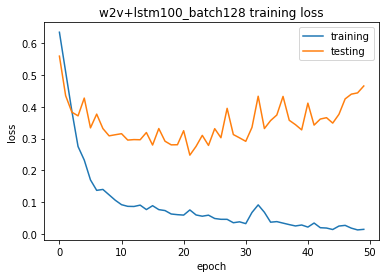

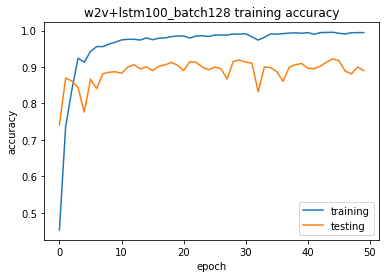

In [18]:
utils.train_full_test_once(train_dataloader, test_dataloader, model, loss_fn, opt, task_name="w2v+lstm100_batch128", epochs=epochs, print_every=1, img_dir=output_dir)

In [19]:
torch.save(model.state_dict(), output_dir+"w2v_lstmlen100_batch128.pt")